In [5]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os


In [7]:
# Load API key from a separate key file
api_key_file = 'api_key.txt'
if not os.path.exists(api_key_file):
    raise FileNotFoundError(f"The API key file '{api_key_file}' was not found. Please ensure it exists in the same directory as this script.")

with open(api_key_file, 'r') as file:
    api_key = file.read().strip()


In [8]:
# API Endpoint and parameters
url = f"https://api.eia.gov/v2/total-energy/data/?api_key={api_key}&frequency=annual&data[0]=value&start=1970&end=2022&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000"

In [24]:
# Fetching the data
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
elif response.status_code == 403:
    raise Exception("API request returned a 403 Forbidden error. Please check if your API key is valid and has the appropriate permissions.")
else:
    raise Exception(f"API request failed with status code {response.status_code}")


In [25]:
# Processing the data
if 'response' in data and 'data' in data['response']:
    df = pd.json_normalize(data, record_path=['response', 'data'])
else:
    raise KeyError("The expected keys 'response' or 'data' were not found in the API response.")


In [26]:
df.columns
df.info

<bound method DataFrame.info of      period      msn                                  seriesDescription  \
0      2022  AFGVBUS  U.S. Government Other Mobility Fuels Consumpti...   
1      2022  ZWHDPUS       Heating Degree-Days, United States in Number   
2      2022  ZWHDPC9             Heating Degree-Days, Pacific in Number   
3      2022  ZWHDPC8            Heating Degree-Days, Mountain in Number   
4      2022  ZWHDPC7  Heating Degree-Days, West South Central in Number   
...     ...      ...                                                ...   
4995   2018  ARTCBUS  Asphalt and Road Oil Product Supplied in Trill...   
4996   2018  ARNFPUS  Asphalt & Road Oil Non-Combustion Consumption ...   
4997   2018  ARNFBUS  Asphalt & Road Oil Non-Combustion Consumption ...   
4998   2018  ARICPUS  Asphalt and Road Oil Consumed by the Industria...   
4999   2018  ARICBUS  Asphalt and Road Oil Consumed by the Industria...   

        value                      unit  
0         1.2            

In [27]:
# Extracting necessary columns and filtering the data
if 'period' in df.columns and 'value' in df.columns and 'seriesDescription' in df.columns:
    df = df[['period', 'value', 'seriesDescription', 'unit']]
else:
    raise KeyError("The required columns 'period', 'value', and 'seriesDescription' are not available in the dataset.")

df.columns = ['Year', 'Total_Energy', 'Description', 'Unit']


In [28]:
# Removing rows with invalid values
df = df[df['Total_Energy'] != 'Not Available']
df['Total_Energy'] = pd.to_numeric(df['Total_Energy'], errors='coerce')
df.dropna(inplace=True)

In [34]:
# Filtering the data to focus on total energy generation
df_total_energy = df[df['Description'].str.contains('Total Energy', case=False, na=False)]

In [35]:
# Converting all energy units to kWh in Billions
def convert_to_kwh(value, unit):
    conversion_factors = {
        'Trillion Btu': 293071.07 / 1e9,  # Trillion Btu to kWh in Billions
        'Quadrillion Btu': 293071070.0 / 1e9,  # Quadrillion Btu to kWh in Billions
        'Million Btu': 293.07107 / 1e9,  # Million Btu to kWh in Billions
        'Billion Btu': 293071.07 / 1e9 / 1000,  # Billion Btu to kWh in Billions
        'kWh': 1 / 1e9,  # kWh to kWh in Billions
        'Million kWh': 1 / 1000,  # Million kWh to kWh in Billions
        'Billion kWh': 1,  # Billion kWh to kWh in Billions
        'Thousand kWh': 1 / 1e6  # Thousand kWh to kWh in Billions
    }
    return value * conversion_factors.get(unit, 0)

In [36]:
# Converting 'Year' to datetime format
df_total_energy['Year'] = pd.to_datetime(df_total_energy['Year'], format='%Y', errors='coerce')
df_total_energy.dropna(subset=['Year'], inplace=True)

C:\Users\Johnathan\AppData\Local\Temp\ipykernel_12896\3162649503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_energy['Year'] = pd.to_datetime(df_total_energy['Year'], format='%Y', errors='coerce')
C:\Users\Johnathan\AppData\Local\Temp\ipykernel_12896\3162649503.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_energy.dropna(subset=['Year'], inplace=True)


In [37]:
# Grouping data by Year
df_grouped = df_total_energy.groupby('Year')['Total_Energy'].sum().reset_index()

In [38]:
# Grouping data by Year and Region
df_grouped = df.groupby(['Year', 'Region'])['Total_Energy'].mean().reset_index()

KeyError: 'Region'

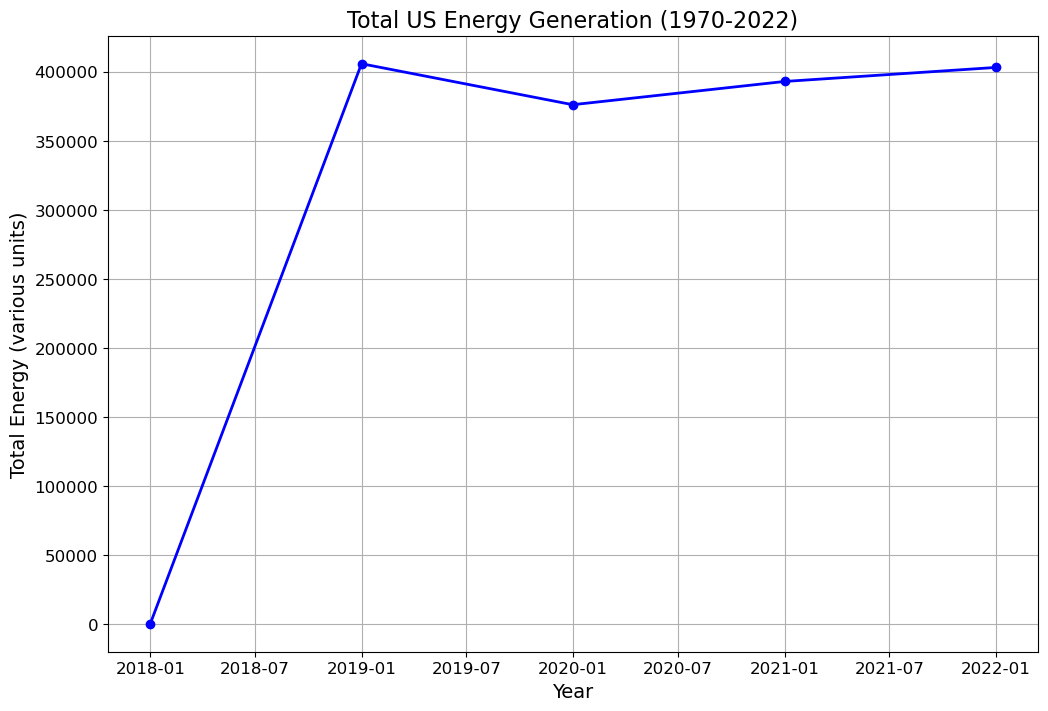

In [39]:
# Plotting the historical data for years 1970 to 2022 as a line graph
plt.figure(figsize=(12, 8))
plt.plot(df_grouped['Year'], df_grouped['Total_Energy'], marker='o', linestyle='-', color='b', linewidth=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Energy (various units)', fontsize=14)
plt.title('Total US Energy Generation (1970-2022)', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [40]:
# Fitting Prophet Model (for total US energy generation)
df_grouped.columns = ['ds', 'y']
df_grouped['ds'] = pd.to_datetime(df_grouped['ds'], format='%Y')

model = Prophet()
model.fit(df_grouped)

23:23:10 - cmdstanpy - INFO - Chain [1] start processing
23:23:10 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# Creating a future dataframe to predict for the next 10 years
future = model.make_future_dataframe(periods=10, freq='Y')

c:\Users\Johnathan\anaconda3\envs\dev1\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [42]:
# Forecasting future values
forecast = model.predict(future)

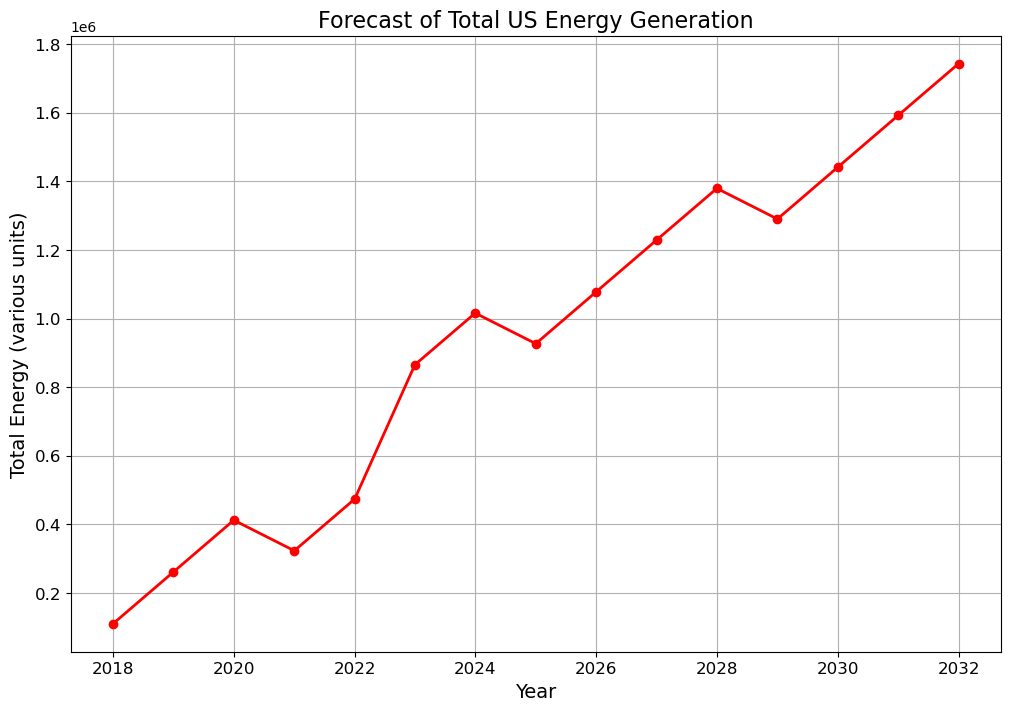

In [43]:
# Plotting forecast
plt.figure(figsize=(12, 8))
plt.plot(forecast['ds'], forecast['yhat'], marker='o', linestyle='-', color='r', linewidth=2)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Energy (various units)', fontsize=14)
plt.title('Forecast of Total US Energy Generation', fontsize=16)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()